# Multi-Class Image Classification Model for Fruits and Vegetables Image Recognition Using TensorFlow Take 5
### David Lowe
### April 21, 2022

SUMMARY: This project aims to construct a predictive model using a TensorFlow convolutional neural network (CNN) and document the end-to-end steps using a template. The Fruits and Vegetables Image Recognition dataset is a multi-class classification situation where we attempt to predict one of several (more than two) possible outcomes.

INTRODUCTION: The dataset owner collected over 4,300 pieces of fruit and vegetable images and created a dataset that includes 36 classes. The idea was to build an application that recognizes the food items from the captured photo and provides different recipes that can be made using the food items.

ANALYSIS: The NASNetMobile model's performance achieved an accuracy score of 89.74% after 40 epochs using a separate validation dataset. After tuning the learning rate, we improved the accuracy rate to 95.16% using the same validation dataset. When we applied the model to the test dataset, the model achieved an accuracy score of 91.92%.

CONCLUSION: In this iteration, the TensorFlow NASNetMobile CNN model appeared suitable for modeling this dataset.

Dataset ML Model: Multi-Class classification with numerical features

Dataset Used: Kritik Seth, "Fruits and Vegetables Image Recognition Dataset," Kaggle 2020

Dataset Reference: https://www.kaggle.com/datasets/kritikseth/fruit-and-vegetable-image-recognition

One source of potential performance benchmarks: https://www.kaggle.com/datasets/kritikseth/fruit-and-vegetable-image-recognition/code

# Task 1 - Prepare Environment

In [1]:
# # Install the packages to support accessing environment variable and SQL databases
# !pip install python-dotenv PyMySQL boto3

In [2]:
# Retrieve CPU information from the system
ncpu = !nproc
print("The number of available CPUs is:", ncpu[0])

The number of available CPUs is: 12


In [3]:
# Retrieve memory configuration information
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

Your runtime has 89.6 gigabytes of available RAM



In [4]:
# Retrieve GPU configuration information
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
print(gpu_info)

Sun Apr 10 20:28:28 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    44W / 400W |      0MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
# # Mount Google Drive locally for loading the dotenv files
# from dotenv import load_dotenv
# from google.colab import drive
# drive.mount('/content/gdrive')
# gdrivePrefix = '/content/gdrive/My Drive/Colab_Downloads/'
# env_path = '/content/gdrive/My Drive/Colab Notebooks/'
# dotenv_path = env_path + "python_script.env"
# load_dotenv(dotenv_path=dotenv_path)

## 1.a) Load libraries and modules

In [6]:
# Set the random seed number for reproducible results
RNG_SEED = 888

In [7]:
import random
random.seed(RNG_SEED)
import numpy as np
np.random.seed(RNG_SEED)
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import sys
import math
# import boto3
import zipfile
from datetime import datetime
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

import tensorflow as tf
tf.random.set_seed(RNG_SEED)
from tensorflow import keras
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## 1.b) Set up the controlling parameters and functions

In [8]:
# Begin the timer for the script processing
START_TIME_SCRIPT = datetime.now()

In [9]:
# Set up the number of CPU cores available for multi-thread processing
N_JOBS = 1

# Set up the flag to stop sending progress emails (setting to True will send status emails!)
NOTIFY_STATUS = False

# Set the percentage sizes for splitting the dataset
TEST_SET_RATIO = 0.2
VAL_SET_RATIO = 0.2

# Set the number of folds for cross validation
N_FOLDS = 5
N_ITERATIONS = 1

# Set various default modeling parameters
DEFAULT_LOSS = 'categorical_crossentropy'
DEFAULT_METRICS = ['accuracy']
INITIAL_LR = 0.0001
DEFAULT_OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=INITIAL_LR)
CLASSIFIER_ACTIVATION = 'softmax'
MAX_EPOCHS = 20
BATCH_SIZE = 16
NUM_CLASSES = 36
# CLASS_LABELS = []
# CLASS_NAMES = []
# RAW_IMAGE_SIZE = (250, 250)
TARGET_IMAGE_SIZE = (224, 224)
INPUT_IMAGE_SHAPE = (TARGET_IMAGE_SIZE[0], TARGET_IMAGE_SIZE[1], 3)

# Define the labels to use for graphing the data
TRAIN_METRIC = "accuracy"
VALIDATION_METRIC = "val_accuracy"
TRAIN_LOSS = "loss"
VALIDATION_LOSS = "val_loss"

# Define the directory locations and file names
STAGING_DIR = 'staging/'
TRAIN_DIR = 'staging/train/'
VALID_DIR = 'staging/validation/'
TEST_DIR = 'staging/test/'
TRAIN_DATASET = 'archive.zip'
# VALID_DATASET = ''
# TEST_DATASET = ''
# TRAIN_LABELS = ''
# VALID_LABELS = ''
# TEST_LABELS = ''
# OUTPUT_DIR = 'staging/'
# SAMPLE_SUBMISSION_CSV = 'sample_submission.csv'
# FINAL_SUBMISSION_CSV = 'submission.csv'

# Check the number of GPUs accessible through TensorFlow
print('Num GPUs Available:', len(tf.config.list_physical_devices('GPU')))

# Print out the TensorFlow version for confirmation
print('TensorFlow version:', tf.__version__)

Num GPUs Available: 1
TensorFlow version: 2.8.0


In [10]:
# Set up the email notification function
def status_notify(msg_text):
    access_key = os.environ.get('SNS_ACCESS_KEY')
    secret_key = os.environ.get('SNS_SECRET_KEY')
    aws_region = os.environ.get('SNS_AWS_REGION')
    topic_arn = os.environ.get('SNS_TOPIC_ARN')
    if (access_key is None) or (secret_key is None) or (aws_region is None):
        sys.exit("Incomplete notification setup info. Script Processing Aborted!!!")
    sns = boto3.client('sns', aws_access_key_id=access_key, aws_secret_access_key=secret_key, region_name=aws_region)
    response = sns.publish(TopicArn=topic_arn, Message=msg_text)
    if response['ResponseMetadata']['HTTPStatusCode'] != 200 :
        print('Status notification not OK with HTTP status code:', response['ResponseMetadata']['HTTPStatusCode'])

In [11]:
if NOTIFY_STATUS: status_notify('(TensorFlow Multi-Class) Task 1 - Prepare Environment has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [12]:
if NOTIFY_STATUS: status_notify('(TensorFlow Multi-Class) Task 1 - Prepare Environment completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

# Task 2 - Load and Prepare Images

In [13]:
if NOTIFY_STATUS: status_notify('(TensorFlow Multi-Class) Task 2 - Load and Prepare Images has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [14]:
# Clean up the old files and download directories before receiving new ones
!rm -rf staging/
# !rm archive.zip
!mkdir staging/

In [15]:
if not os.path.exists(TRAIN_DATASET):
    !wget https://dainesanalytics.com/datasets/kaggle-kritikseth-fruit-vegetable-image/archive.zip

--2022-04-10 20:28:32--  https://dainesanalytics.com/datasets/kaggle-kritikseth-fruit-vegetable-image/archive.zip
Resolving dainesanalytics.com (dainesanalytics.com)... 18.67.0.24, 18.67.0.27, 18.67.0.19, ...
Connecting to dainesanalytics.com (dainesanalytics.com)|18.67.0.24|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2130757290 (2.0G) [application/zip]
Saving to: ‘archive.zip’

archive.zip         100%[===================>]   1.98G  35.6MB/s    in 48s     

2022-04-10 20:29:20 (42.0 MB/s) - ‘archive.zip’ saved [2130757290/2130757290]



In [16]:
zip_ref = zipfile.ZipFile(TRAIN_DATASET, 'r')
zip_ref.extractall(STAGING_DIR)
zip_ref.close()

In [17]:
CLASS_LABELS = os.listdir(TRAIN_DIR)
print(CLASS_LABELS)

['onion', 'tomato', 'turnip', 'apple', 'pomegranate', 'sweetcorn', 'ginger', 'peas', 'lettuce', 'garlic', 'watermelon', 'potato', 'paprika', 'eggplant', 'carrot', 'bell pepper', 'sweetpotato', 'jalepeno', 'orange', 'pineapple', 'soy beans', 'lemon', 'kiwi', 'chilli pepper', 'cucumber', 'raddish', 'cabbage', 'spinach', 'mango', 'pear', 'capsicum', 'beetroot', 'grapes', 'corn', 'cauliflower', 'banana']


In [18]:
# Brief listing of training image files for each class
for c_label in CLASS_LABELS:
    training_class_dir = os.path.join(TRAIN_DIR, c_label)
    training_class_files = os.listdir(training_class_dir)
    print('Number of training images for', c_label, ':', len(os.listdir(training_class_dir)))
    print('Training samples for', c_label, ':', training_class_files[:5],'\n')

Number of training images for onion : 94
Training samples for onion : ['Image_84.jpg', 'Image_1.jpg', 'Image_40.jpg', 'Image_3.jpg', 'Image_94.png'] 

Number of training images for tomato : 92
Training samples for tomato : ['Image_84.jpg', 'Image_1.jpg', 'Image_40.jpg', 'Image_3.jpg', 'Image_80.png'] 

Number of training images for turnip : 98
Training samples for turnip : ['Image_84.jpg', 'Image_64.jpg', 'Image_1.jpg', 'Image_40.jpg', 'Image_3.jpg'] 

Number of training images for apple : 68
Training samples for apple : ['Image_64.jpg', 'Image_1.jpg', 'Image_40.jpg', 'Image_3.jpg', 'Image_87.jpg'] 

Number of training images for pomegranate : 79
Training samples for pomegranate : ['Image_64.jpg', 'Image_1.jpg', 'Image_40.jpg', 'Image_3.jpg', 'Image_80.png'] 

Number of training images for sweetcorn : 91
Training samples for sweetcorn : ['Image_84.jpg', 'Image_1.jpg', 'Image_40.jpg', 'Image_3.jpg', 'Image_76.jpg'] 

Number of training images for ginger : 68
Training samples for ginger 

In [19]:
# Brief listing of test image files for each class
for c_label in CLASS_LABELS:
    test_class_dir = os.path.join(VALID_DIR, c_label)
    test_class_files = os.listdir(test_class_dir)
    print('Number of test images for', c_label, ':', len(os.listdir(test_class_dir)))
    print('Training samples for', c_label, ':')
    print(test_class_files[:5],'\n')

Number of test images for onion : 10
Training samples for onion :
['Image_1.jpg', 'Image_3.jpg', 'Image_8.jpg', 'Image_5.jpg', 'Image_6.jpg'] 

Number of test images for tomato : 10
Training samples for tomato :
['Image_1.jpg', 'Image_3.jpg', 'Image_7.jpg', 'Image_8.jpg', 'Image_5.jpg'] 

Number of test images for turnip : 10
Training samples for turnip :
['Image_1.jpg', 'Image_3.jpg', 'Image_7.jpg', 'Image_8.jpg', 'Image_5.jpg'] 

Number of test images for apple : 10
Training samples for apple :
['Image_1.jpg', 'Image_3.jpg', 'Image_7.jpg', 'Image_8.jpg', 'Image_5.jpg'] 

Number of test images for pomegranate : 10
Training samples for pomegranate :
['Image_1.jpg', 'Image_3.jpg', 'Image_7.jpg', 'Image_8.jpg', 'Image_5.jpg'] 

Number of test images for sweetcorn : 10
Training samples for sweetcorn :
['Image_1.jpg', 'Image_3.jpg', 'Image_7.jpg', 'Image_8.jpg', 'Image_5.jpg'] 

Number of test images for ginger : 10
Training samples for ginger :
['Image_1.jpg', 'Image_3.jpg', 'Image_7.jpg'

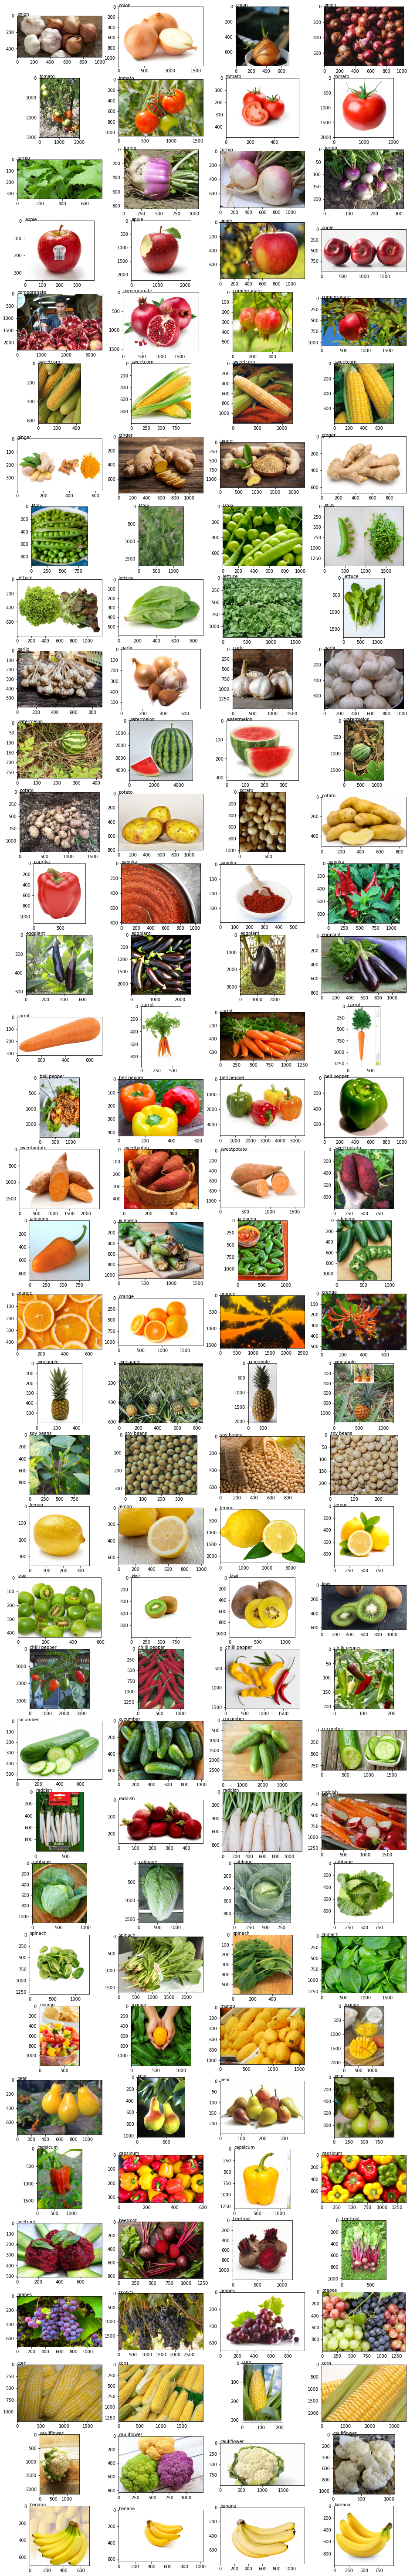

In [20]:
# Plot some training images from the dataset
nrows = len(CLASS_LABELS)
ncols = 4
training_examples = []
example_labels = []

fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 3)

for c_label in CLASS_LABELS:
    training_class_dir = os.path.join(TRAIN_DIR, c_label)
    training_class_files = os.listdir(training_class_dir)
    for j in range(ncols):
        training_examples.append(training_class_dir + '/' + training_class_files[j])
        example_labels.append(c_label)
    # print(training_examples)
    # print(example_labels)

for i, img_path in enumerate(training_examples):
    # Set up subplot; subplot indices start at 1
    sp = plt.subplot(nrows, ncols, i+1)
    sp.text(0, 0, example_labels[i])
    # sp.axis('Off')
    img = mpimg.imread(img_path)
    plt.imshow(img)
plt.show()

In [21]:
datagen_kwargs = dict(rescale=1./255)
training_datagen = ImageDataGenerator(**datagen_kwargs)
validation_datagen = ImageDataGenerator(**datagen_kwargs)
dataflow_kwargs = dict(class_mode="categorical")

do_data_augmentation = True
if do_data_augmentation:
    training_datagen = ImageDataGenerator(rotation_range=45,
                                          horizontal_flip=True,
                                          vertical_flip=True,
                                          **datagen_kwargs)

print('Loading and pre-processing the training images...')
training_generator = training_datagen.flow_from_directory(directory=TRAIN_DIR,
                                                          target_size=TARGET_IMAGE_SIZE,
                                                          batch_size=BATCH_SIZE,
                                                          shuffle=True,
                                                          seed=RNG_SEED,
                                                          **dataflow_kwargs)
print('Number of training image batches per epoch of modeling:', len(training_generator))

print('Loading and pre-processing the validation images...')
validation_generator = validation_datagen.flow_from_directory(directory=VALID_DIR,
                                                              target_size=TARGET_IMAGE_SIZE,
                                                              batch_size=BATCH_SIZE,
                                                              shuffle=False,
                                                              **dataflow_kwargs)
print('Number of validation image batches per epoch of modeling:', len(validation_generator))

Loading and pre-processing the training images...
Found 3115 images belonging to 36 classes.
Number of training image batches per epoch of modeling: 195
Loading and pre-processing the validation images...
Found 351 images belonging to 36 classes.
Number of validation image batches per epoch of modeling: 22


In [22]:
if NOTIFY_STATUS: status_notify('(TensorFlow Multi-Class) Task 2 - Load and Prepare Images completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

# Task 3 - Define and Train Models

In [23]:
if NOTIFY_STATUS: status_notify('(TensorFlow Multi-Class) Task 3 - Define and Train Models has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [24]:
# Define the function for plotting training results for comparison
def plot_metrics(history):
    fig, axs = plt.subplots(1, 2, figsize=(24, 15))
    metrics =  [TRAIN_LOSS, TRAIN_METRIC]
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch, history.history[metric], color='blue', label='Train')
        plt.plot(history.epoch, history.history['val_'+metric], color='red', linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == TRAIN_LOSS:
            plt.ylim([0, plt.ylim()[1]])
        else:
            plt.ylim([0, 1])
        plt.legend()

In [25]:
# Define the baseline model for benchmarking
def create_nn_model(input_param=INPUT_IMAGE_SHAPE, output_param=NUM_CLASSES, dense_nodes=2048,
                    classifier_activation=CLASSIFIER_ACTIVATION, loss_param=DEFAULT_LOSS,
                    opt_param=DEFAULT_OPTIMIZER, metrics_param=DEFAULT_METRICS):
    base_model = keras.applications.nasnet.NASNetMobile(include_top=False, weights='imagenet', input_shape=input_param)
    nn_model = keras.models.Sequential()
    nn_model.add(base_model)
    nn_model.add(keras.layers.Flatten())
    nn_model.add(keras.layers.Dense(dense_nodes, activation='relu')),
    nn_model.add(keras.layers.Dense(output_param, activation=classifier_activation))
    nn_model.compile(loss=loss_param, optimizer=opt_param, metrics=metrics_param)
    return nn_model

In [26]:
# Initialize the neural network model and get the training results for plotting graph
start_time_module = datetime.now()
tf.keras.utils.set_random_seed(RNG_SEED)
baseline_model = create_nn_model()
baseline_model_history = baseline_model.fit(training_generator,
                                            epochs=MAX_EPOCHS,
                                            validation_data=validation_generator,
                                            verbose=1)
print('Total time for model fitting:', (datetime.now() - start_time_module))

20004864/19993432 [==============================] - 0s 0us/step
Epoch 1/20
 11/195 [>.............................] - ETA: 1:39 - loss: 6.8073 - accuracy: 0.1170

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


 29/195 [===>..........................] - ETA: 1:50 - loss: 4.5671 - accuracy: 0.2222

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


195/195 [==============================] - 198s 852ms/step - loss: 2.0051 - accuracy: 0.5149 - val_loss: 1.1313 - val_accuracy: 0.6895
Epoch 2/20
195/195 [==============================] - 162s 829ms/step - loss: 0.8915 - accuracy: 0.7236 - val_loss: 0.6895 - val_accuracy: 0.7778
Epoch 3/20
195/195 [==============================] - 162s 834ms/step - loss: 0.6273 - accuracy: 0.8010 - val_loss: 0.6127 - val_accuracy: 0.8291
Epoch 4/20
195/195 [==============================] - 163s 835ms/step - loss: 0.5174 - accuracy: 0.8289 - val_loss: 0.5748 - val_accuracy: 0.8063
Epoch 5/20
195/195 [==============================] - 163s 834ms/step - loss: 0.3956 - accuracy: 0.8690 - val_loss: 0.4760 - val_accuracy: 0.8575
Epoch 6/20
195/195 [==============================] - 163s 833ms/step - loss: 0.3475 - accuracy: 0.8848 - val_loss: 0.6330 - val_accuracy: 0.8148
Epoch 7/20
195/195 [==============================] - 163s 833ms/step - loss: 0.2975 - accuracy: 0.8947 - val_loss: 0.4984 - val_accura

In [27]:
baseline_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 NASNet (Functional)         (None, 7, 7, 1056)        4269716   
                                                                 
 flatten (Flatten)           (None, 51744)             0         
                                                                 
 dense (Dense)               (None, 2048)              105973760 
                                                                 
 dense_1 (Dense)             (None, 36)                73764     
                                                                 
Total params: 110,317,240
Trainable params: 110,280,502
Non-trainable params: 36,738
_________________________________________________________________


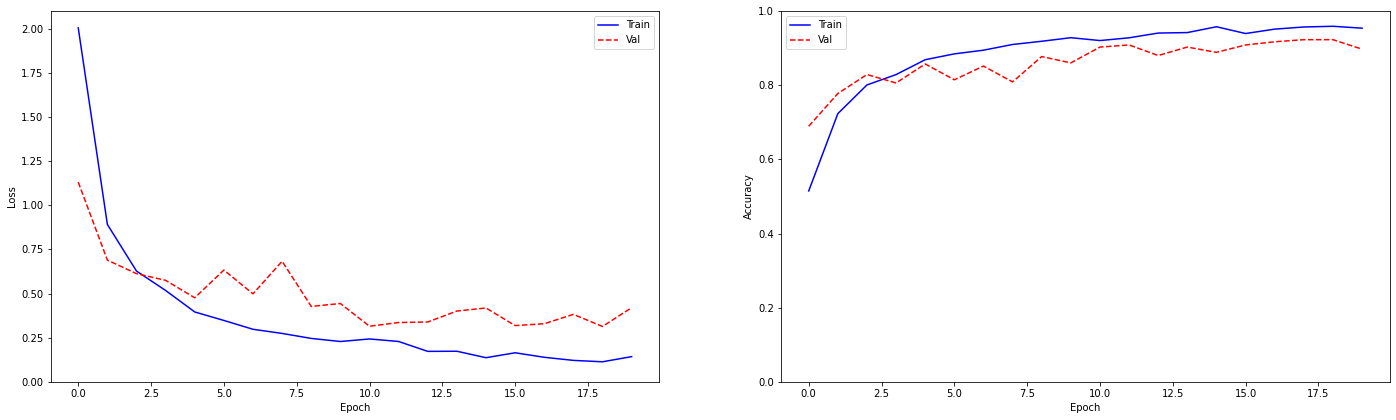

In [28]:
plot_metrics(baseline_model_history)

In [29]:
if NOTIFY_STATUS: status_notify('(TensorFlow Multi-Class) Task 3 - Define and Train Models completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

# Task 4 - Tune and Optimize Models

In [30]:
if NOTIFY_STATUS: status_notify('(TensorFlow Multi-Class) Task 4 - Tune and Optimize Models has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [31]:
# Initialize the neural network model and get the training results for plotting graph
start_time_module = datetime.now()
TUNING_LR = INITIAL_LR / 2
TUNE_OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=TUNING_LR)
MINIMUM_LR = TUNING_LR / 4
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=1, factor=0.5, min_lr=MINIMUM_LR)
tf.keras.utils.set_random_seed(RNG_SEED)
tune_model = create_nn_model(opt_param=TUNE_OPTIMIZER)
tune_model_history = tune_model.fit(training_generator,
                                    epochs=MAX_EPOCHS,
                                    validation_data=validation_generator,
                                    callbacks=[learning_rate_reduction],
                                    verbose=1)
print('Total time for model fitting:', (datetime.now() - start_time_module))

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch 1/20
 36/195 [====>.........................] - ETA: 1:42 - loss: 3.5437 - accuracy: 0.2417

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


195/195 [==============================] - 188s 850ms/step - loss: 2.0135 - accuracy: 0.4825 - val_loss: 0.9787 - val_accuracy: 0.6952 - lr: 5.0000e-05
Epoch 2/20
195/195 [==============================] - 163s 835ms/step - loss: 0.9818 - accuracy: 0.7034 - val_loss: 0.6605 - val_accuracy: 0.7806 - lr: 5.0000e-05
Epoch 3/20
195/195 [==============================] - 163s 835ms/step - loss: 0.6930 - accuracy: 0.7942 - val_loss: 0.5350 - val_accuracy: 0.8319 - lr: 5.0000e-05
Epoch 4/20
195/195 [==============================] - 162s 829ms/step - loss: 0.5921 - accuracy: 0.8116 - val_loss: 0.4775 - val_accuracy: 0.8661 - lr: 5.0000e-05
Epoch 5/20
195/195 [==============================] - 162s 830ms/step - loss: 0.4740 - accuracy: 0.8510 - val_loss: 0.4945 - val_accuracy: 0.8575 - lr: 5.0000e-05
Epoch 6/20
195/195 [==============================] - 162s 830ms/step - loss: 0.3977 - accuracy: 0.8584 - val_loss: 0.3369 - val_accuracy: 0.8946 - lr: 5.0000e-05
Epoch 7/20
195/195 [=============

In [32]:
if NOTIFY_STATUS: status_notify('(TensorFlow Multi-Class) Task 4 - Tune and Optimize Models completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

# Task 5 - Finalize Model and Make Predictions

In [33]:
if NOTIFY_STATUS: status_notify('(TensorFlow Multi-Class) Task 5 - Finalize Model and Make Predictions has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

### 5.a) Train the Final Model

In [34]:
FINAL_LR = 0.0000125
FINAL_OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=FINAL_LR)
FINAL_EPOCHS = MAX_EPOCHS
tf.keras.utils.set_random_seed(RNG_SEED)
final_model = create_nn_model(opt_param=FINAL_OPTIMIZER)
final_model.fit(training_generator, epochs=FINAL_EPOCHS, verbose=1)
final_model.summary()

Epoch 1/20
 19/195 [=>............................] - ETA: 2:18 - loss: 3.8790 - accuracy: 0.0970

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


 87/195 [============>.................] - ETA: 1:21 - loss: 2.8667 - accuracy: 0.2769

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


195/195 [==============================] - 166s 740ms/step - loss: 2.2544 - accuracy: 0.4003
Epoch 2/20
195/195 [==============================] - 144s 739ms/step - loss: 1.2023 - accuracy: 0.6498
Epoch 3/20
195/195 [==============================] - 144s 739ms/step - loss: 0.9586 - accuracy: 0.7194
Epoch 4/20
195/195 [==============================] - 144s 739ms/step - loss: 0.7878 - accuracy: 0.7461
Epoch 5/20
195/195 [==============================] - 145s 741ms/step - loss: 0.7200 - accuracy: 0.7724
Epoch 6/20
195/195 [==============================] - 144s 740ms/step - loss: 0.6049 - accuracy: 0.7978
Epoch 7/20
195/195 [==============================] - 144s 738ms/step - loss: 0.5165 - accuracy: 0.8315
Epoch 8/20
195/195 [==============================] - 144s 740ms/step - loss: 0.4670 - accuracy: 0.8465
Epoch 9/20
195/195 [==============================] - 144s 738ms/step - loss: 0.4232 - accuracy: 0.8613
Epoch 10/20
195/195 [==============================] - 145s 741ms/step - lo

### 5.b) Load Test Dataset and Make Predictions

In [35]:
# Brief listing of test image files for each class
for c_label in CLASS_LABELS:
    test_class_dir = os.path.join(TEST_DIR, c_label)
    test_class_files = os.listdir(test_class_dir)
    print('Number of test images for', c_label, ':', len(os.listdir(test_class_dir)))
    print('Training samples for', c_label, ':')
    print(test_class_files[:5],'\n')

Number of test images for onion : 10
Training samples for onion :
['Image_1.jpg', 'Image_3.jpg', 'Image_8.jpg', 'Image_5.jpg', 'Image_6.jpg'] 

Number of test images for tomato : 10
Training samples for tomato :
['Image_1.jpg', 'Image_3.jpg', 'Image_7.jpg', 'Image_8.jpg', 'Image_5.jpg'] 

Number of test images for turnip : 10
Training samples for turnip :
['Image_1.jpg', 'Image_3.jpg', 'Image_7.jpg', 'Image_8.jpg', 'Image_5.jpg'] 

Number of test images for apple : 10
Training samples for apple :
['Image_1.jpg', 'Image_3.jpg', 'Image_7.jpg', 'Image_8.jpg', 'Image_5.jpg'] 

Number of test images for pomegranate : 10
Training samples for pomegranate :
['Image_1.jpg', 'Image_3.jpg', 'Image_7.jpg', 'Image_8.jpg', 'Image_5.jpg'] 

Number of test images for sweetcorn : 10
Training samples for sweetcorn :
['Image_1.jpg', 'Image_3.jpg', 'Image_7.jpg', 'Image_8.jpg', 'Image_5.jpg'] 

Number of test images for ginger : 10
Training samples for ginger :
['Image_1.jpg', 'Image_3.jpg', 'Image_7.jpg'

In [36]:
datagen_kwargs = dict(rescale=1./255)
test_datagen = ImageDataGenerator(**datagen_kwargs)
dataflow_kwargs = dict(class_mode="categorical")

print('Loading and pre-processing the test images...')
test_generator = validation_datagen.flow_from_directory(directory=TEST_DIR,
                                                        target_size=TARGET_IMAGE_SIZE,
                                                        batch_size=BATCH_SIZE,
                                                        shuffle=False,
                                                        **dataflow_kwargs)
print('Number of test image batches per epoch of modeling:', len(test_generator))

Loading and pre-processing the test images...
Found 359 images belonging to 36 classes.
Number of test image batches per epoch of modeling: 23


In [37]:
# Print the labels used for the modeling
print(test_generator.class_indices)

{'apple': 0, 'banana': 1, 'beetroot': 2, 'bell pepper': 3, 'cabbage': 4, 'capsicum': 5, 'carrot': 6, 'cauliflower': 7, 'chilli pepper': 8, 'corn': 9, 'cucumber': 10, 'eggplant': 11, 'garlic': 12, 'ginger': 13, 'grapes': 14, 'jalepeno': 15, 'kiwi': 16, 'lemon': 17, 'lettuce': 18, 'mango': 19, 'onion': 20, 'orange': 21, 'paprika': 22, 'pear': 23, 'peas': 24, 'pineapple': 25, 'pomegranate': 26, 'potato': 27, 'raddish': 28, 'soy beans': 29, 'spinach': 30, 'sweetcorn': 31, 'sweetpotato': 32, 'tomato': 33, 'turnip': 34, 'watermelon': 35}


In [38]:
final_model.evaluate(test_generator, verbose=1)

13/23 [===============>..............] - ETA: 8s - loss: 0.2903 - accuracy: 0.9183

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


23/23 [==============================] - 23s 799ms/step - loss: 0.2983 - accuracy: 0.9192


[0.29830315709114075, 0.9192200303077698]

In [39]:
test_pred = final_model.predict(test_generator)
test_predictions = np.argmax(test_pred, axis=-1)
test_original = test_generator.labels
print('Accuracy Score:', accuracy_score(test_original, test_predictions))
print(confusion_matrix(test_original, test_predictions))
print(classification_report(test_original, test_predictions))

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Accuracy Score: 0.9192200557103064
[[ 7  0  0 ...  0  0  0]
 [ 0  7  0 ...  0  0  0]
 [ 0  0 10 ...  0  0  0]
 ...
 [ 0  0  0 ... 10  0  0]
 [ 0  0  0 ...  0 10  0]
 [ 0  0  0 ...  0  0 10]]
              precision    recall  f1-score   support

           0       0.88      0.70      0.78        10
           1       0.88      0.78      0.82         9
           2       1.00      1.00      1.00        10
           3       0.60      0.90      0.72        10
           4       1.00      1.00      1.00        10
           5       0.80      0.40      0.53        10
           6       1.00      0.90      0.95        10
           7       1.00      1.00      1.00        10
           8       0.77      1.00      0.87        10
           9       0.89      0.80      0.84        10
          10       1.00      1.00      1.00        10
          11       1.00      0.90      0.95        10
          12       0.91      1.00      0.95        10
          13       1.00      1.00      1.00        1

In [40]:
if NOTIFY_STATUS: status_notify('(TensorFlow Multi-Class) Task 5 - Finalize Model and Make Predictions completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [41]:
print ('Total time for the script:',(datetime.now() - START_TIME_SCRIPT))

Total time for the script: 3:00:48.868612
